In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, np.pi),
    n_steps=361,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [12]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation
from teren.utils import get_random_activation

In [13]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, normalize=False):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(antiparallel_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation)
        sae_control[i].append(sae_kl_div)
    
    for i in tqdm(range(len(sorted_features))):  
        saefeat_perturbation = SAEFeaturePerturbation(exp_ref, sorted_features[i], sae, negate=1)
        kl_div = run_perturbation(cfg, exp_ref, saefeat_perturbation)
        results[sorted_features[i][0]]['kl_div'] = kl_div
    

    #print(results.keys())
    #print(control.keys())

    assert [i[0] for i in sorted_features] == list(results.keys())

    feature_activation = torch.Tensor([feature[1] for feature in sorted_features])
    #print(feature_activation)

    recon_feature_dir = sae.W_dec[[feature[0] for feature in sorted_features]]
    feature_dot_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, exp_ref.act)
    #print(feature_act_dot)

    feature_sparsity = sparsity[list(results.keys())]
    #print(feature_sparsity)

    feature_dot_feature = []
    for feature in sorted_features:
        feature_dot_all = torch.einsum("...k, ... j k -> ... j", sae.W_dec[feature[0]], sae.W_dec[[feature_idx for feature_idx in active_features.keys() if feature_idx != feature[0]]])
        feature_dot_feature.append(feature_dot_all.min(dim=-1)[0])
    feature_dot_feature = torch.Tensor(feature_dot_feature)
    #print(feature_other)

    if normalize:
        for i, feature in enumerate(sorted_features):
            feature_activation[i] /= (feature_activation.max(dim=-1)[0])
            feature_dot_act[0][i] /= (feature_dot_act[0].max(dim=-1)[0])
            feature_sparsity[i] /= (feature_sparsity.abs().max(dim=-1)[0])
            feature_dot_feature[i] /= (-1 * feature_dot_feature.min(dim=-1)[0])

    for i, feature in enumerate(sorted_features):
        results[feature[0]]['Feature Activation'] = feature_activation[i]
        results[feature[0]]['Feature Dot Act'] = feature_dot_act[0][i]
        results[feature[0]]['Feature Sparsity'] = feature_sparsity[i]
        results[feature[0]]['Feature Dot Feature'] = feature_dot_feature[i]


    properties = {"Feature Activation": [feature_activation.min(dim=-1)[0].item(), feature_activation.max(dim=-1)[0].item()], 
                  "Feature Dot Act": [feature_dot_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_act.squeeze(0).max(dim=-1)[0].item()], 
                  "Feature Sparsity": [feature_sparsity.min(dim=-1)[0].item(), feature_sparsity.max(dim=-1)[0].item()], 
                  "Feature Dot Feature": [feature_dot_feature.min(dim=-1)[0].item(), feature_dot_feature.max(dim=-1)[0].item()]}

    return results, control, sae_control, properties


In [14]:
def plot_all_results(fig, ax, results, control, sae_control, properties):
    colors = plt.cm.viridis(np.linspace(0,1,len(results.keys())))

    for i, color_property in enumerate(properties.keys()):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

        plot_order = sorted(results.items(), key = lambda item: item[1][color_property])

        for j, (feature_idx, data) in enumerate(plot_order):
            kl_div = data['kl_div']
            ax[i][0].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][1].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)

        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        ax[i][0].set_xlim(0,361)
        ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        ax[i][1].set_xlim(0,361)
        ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][2].set_ylabel("KL divergence to base logits")
        ax[i][2].set_xlim(0,75)
        #ax[i][2].set_ylim(-0.01,2)

        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
        cbar = fig.colorbar(sm, ax=ax[i][2])
        cbar.set_label(color_property)
    

In [15]:
our_prompt = "The capital of France is Paris"
our_tokens = torch.tensor([model.tokenizer.encode(our_prompt)])
cfg.n_ctx = our_tokens.shape[1]

In [16]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 10
    results, controls, sae_controls, properties = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, normalize=False)

    if i == 0:
        all_results = results
        all_properties = properties                                     
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for f_idx, result in results.items():
            all_results[f_idx] = result 
        
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

        for property in properties.keys():
            all_properties[property][0] = min(properties[property][0], all_properties[property][0])
            all_properties[property][1] = max(properties[property][1], all_properties[property][1])
    print(all_properties)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 938, 2121,   11,  607,  749, 1029]])
Prompt:  last fall, her most high
4356
12757
24189
12757
12757
12757
Using 6 active features: {5735: tensor(25.0345), 15738: tensor(2.8676), 21958: tensor(3.0731), 23420: tensor(3.3922), 23577: tensor(3.8408), 24149: tensor(6.4901)}


tensor([[[1.2418e-09]]])
Normalizing direction
tensor([[[1.2418e-08]]])
Normalizing direction


tensor([[[-1.1176e-08]]])
Normalizing direction
tensor([[[-1.7385e-08]]])
Normalizing direction


tensor([[[4.3462e-09]]])
Normalizing direction
tensor([[[1.4901e-08]]])
Normalizing direction


tensor([[[0.]]])
Normalizing direction
tensor([[[4.9671e-09]]])
Normalizing direction


tensor([[[-8.0715e-09]]])
Normalizing direction
tensor([[[-1.7385e-08]]])
Normalizing direction


tensor([[[-1.2418e-09]]])
Normalizing direction
tensor([[[0.]]])
Normalizing direction


tensor([[[-7.4506e-09]]])
Normalizing direction
tensor([[[-3.7253e-09]]])
Normalizing direction


tensor([[[0.]]])
Normalizing direction
tensor([[[-6.2088e-09]]])
Normalizing direction


tensor([[[-7.4506e-09]]])
Normalizing direction
tensor([[[-1.7385e-08]]])
Normalizing direction


tensor([[[4.9671e-09]]])
Normalizing direction
tensor([[[1.9868e-08]]])
Normalizing direction


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


tensor([[[-3.2984e-10]]])
Normalizing direction


tensor([[[-1.5522e-10]]])
Normalizing direction


tensor([[[1.5522e-10]]])
Normalizing direction


100%|██████████| 1/1 [00:17<00:00, 17.36s/it]

{'Feature Activation': [0.0, 0.0], 'Feature Dot Act': [-19.189971923828125, -2.3839526176452637], 'Feature Sparsity': [-3.5773308277130127, -0.9430142641067505], 'Feature Dot Feature': [-0.8139815330505371, -0.17185643315315247]}


/tmp/ipykernel_6447/2590612510.py:19: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)


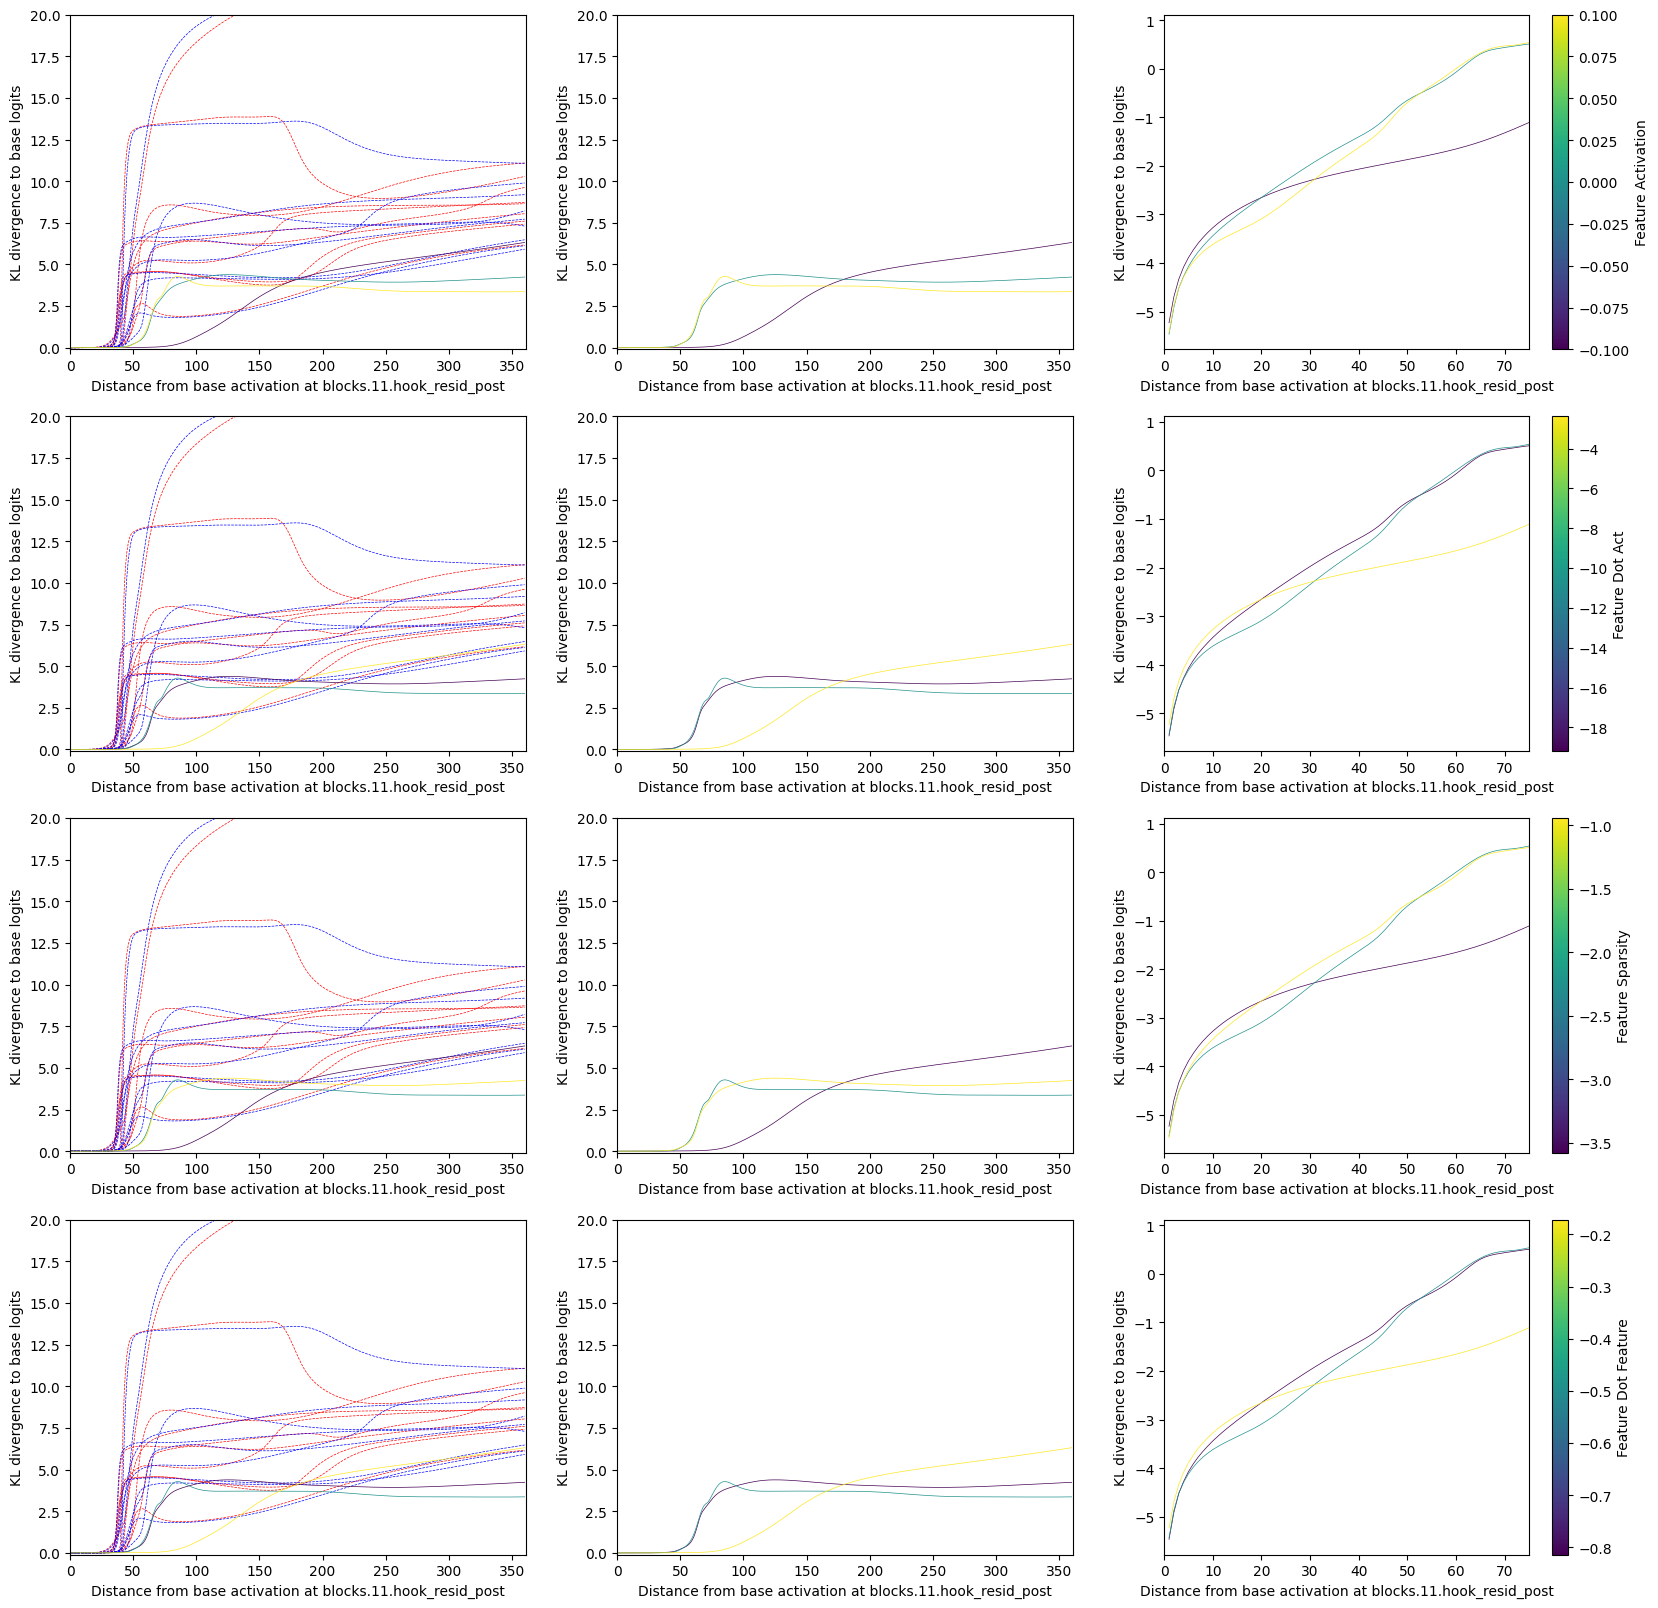

In [17]:
fig, ax = plt.subplots(len(properties.keys()), 3, figsize=(20,5*len(properties.keys())))

plot_all_results(fig, ax, all_results, all_controls, all_sae_controls, all_properties)
fig.show()

In [13]:
syn_cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [14]:
# Examining SAE features
def get_syn_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, reduce=True):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(antiparallel_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)
    syn = defaultdict(list)

    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)

        syn_activation_perturbation = SyntheticActivationPerturbation(exp_ref, thresh, dataset, sae)
        syn_kl_div = run_perturbation(cfg, exp_ref, syn_activation_perturbation, reduce=reduce)
        syn[i].append(syn_kl_div)

    return control, sae_control, syn


In [15]:
def plot_syn_results(fig, ax, control, sae_control, syn):

    i = 0
    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for syn_kl_div in syn.values():
        ax[i][0].plot(syn_kl_div, color='green', linewidth=0.5)
        ax[i][1].plot(syn_kl_div, color='green', linewidth=0.5)
        ax[i][2].plot(np.log10(syn_kl_div), color='green', linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0, 361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0, 361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0, 180)
    #ax[i][2].set_ylim(-0.01, 2)
    

In [22]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 10
    controls, sae_controls, syns = get_syn_results_for_prompt(exp_ref, syn_cfg, sae, n_control=n_control, thresh = 0.05, reduce=True)

    if i == 0:                                    
        all_controls = controls
        all_sae_controls = sae_controls
        all_syns = syns
    else:
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control
        
        for control_idx, syn in syns.items():
            all_syns[n_control*i+control_idx] = syn

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 5290,    11,   356,   389,  1200, 38991,    13,   383,   517,   356]])
Prompt:  worst, we are child abusers. The more we
12757
22864
24189
19226
5807
22864
13033
Using 7 active features: {813: tensor(1.0912), 2065: tensor(3.3712), 3626: tensor(4.1166), 14805: tensor(19.9527), 15017: tensor(4.1741), 17359: tensor(3.3425), 21524: tensor(3.6321)}


Base Recon Error: 132.05010986328125
Target Recon Error: 203.6824188232422


Base Recon Error: 132.05010986328125
Target Recon Error: 141.33380126953125


Base Recon Error: 132.05010986328125
Target Recon Error: 213.25621032714844


Base Recon Error: 132.05010986328125
Target Recon Error: 167.37672424316406


Base Recon Error: 132.05010986328125
Target Recon Error: 155.604736328125


Base Recon Error: 132.05010986328125
Target Recon Error: 122.37299346923828


Base Recon Error: 132.05010986328125
Target Recon Error: 136.30386352539062


Base Recon Error: 132.05010986328125
Target Recon Error: 120.72834014892578


Base Recon Error: 132.05010986328125
Target Recon Error: 130.41131591796875


Base Recon Error: 132.05010986328125
Target Recon Error: 145.00424194335938


100%|██████████| 1/1 [00:26<00:00, 26.55s/it]


In [23]:
print(len(all_syns[0][0]))
print(len(all_controls[0][0]))

100
100


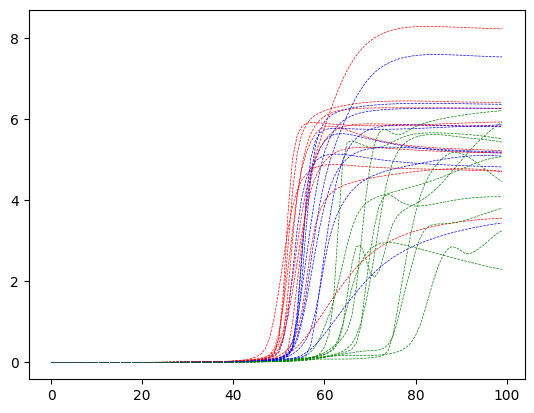

In [24]:
for i in range(n_control):
    plt.plot(all_controls[i][0], color='red', linestyle='--', linewidth=0.5)
    plt.plot(all_sae_controls[i][0], color='blue', linestyle='--', linewidth=0.5)
    plt.plot(all_syns[i][0], color='green', linestyle='--', linewidth=0.5)

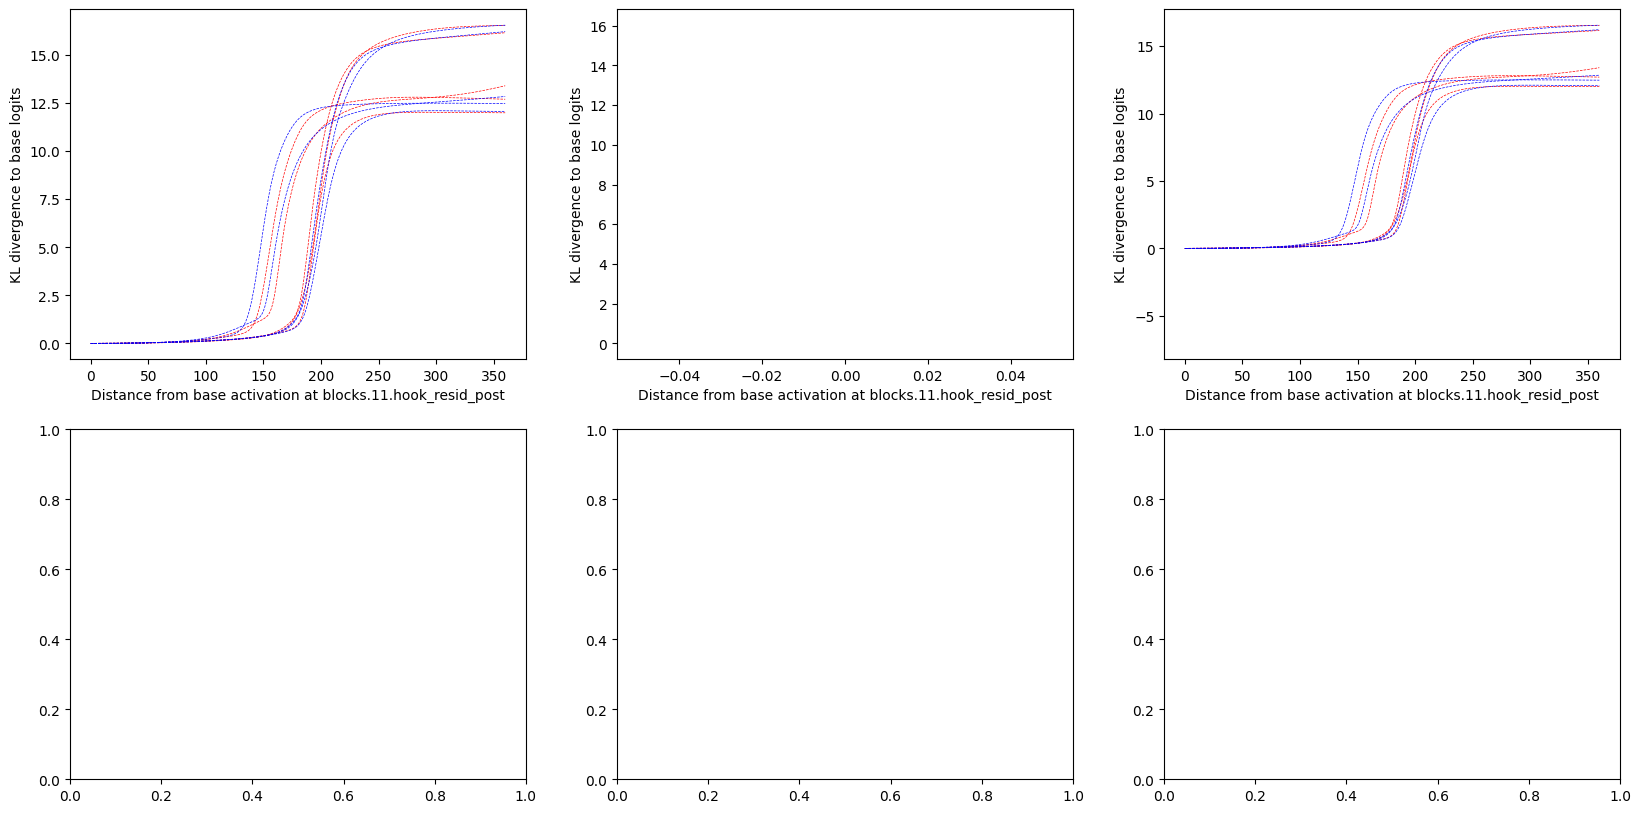

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns)
fig.show()